In [1]:
import os
DATA_DIR = 'Data'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'valid')

In [2]:
IMG_SIZE = 224
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Corn___Common_Rust', 'Corn___Healthy', 'Invalid___Images', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy']


In [3]:
classes = len(CATEGORIES)
classes

7

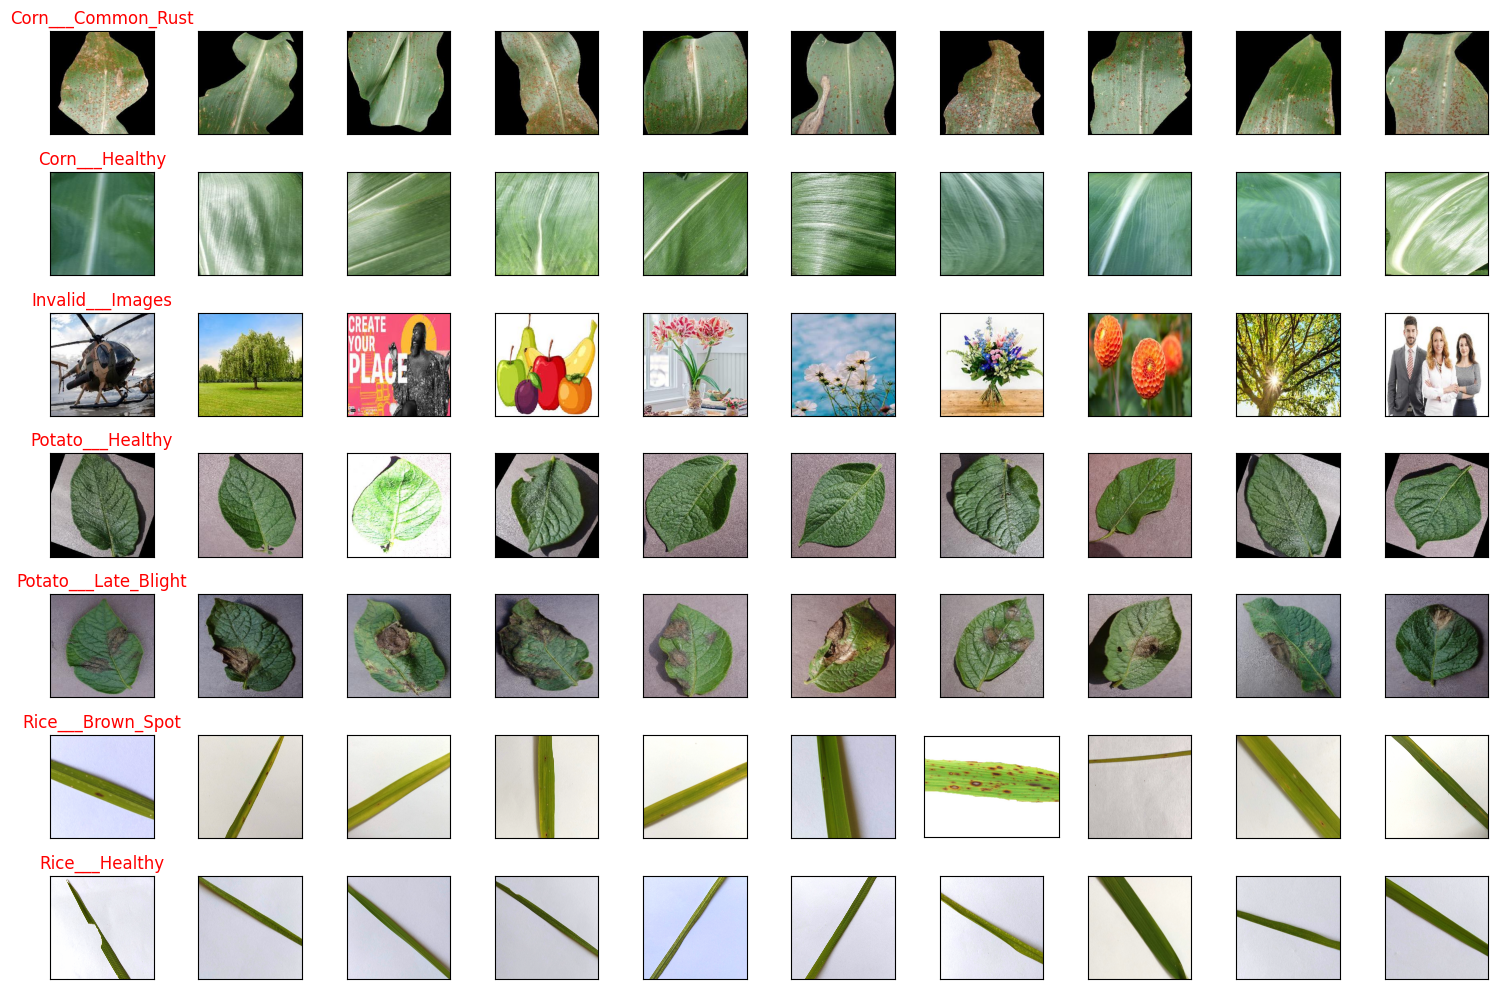

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)

        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

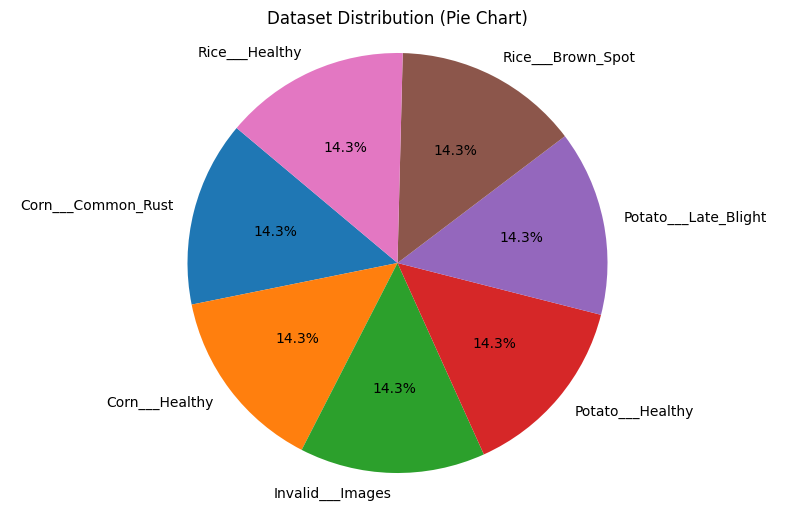

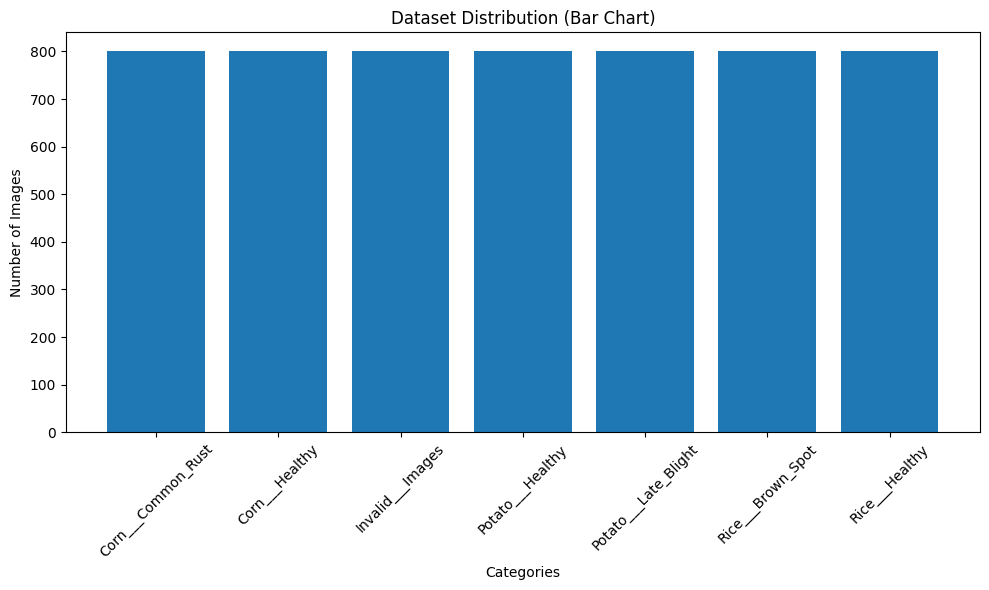

In [5]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
from tqdm import tqdm
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 800/800 [01:11<00:00, 11.23it/s]

5600


In [10]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 200/200 [00:19<00:00, 10.02it/s]

1400


In [11]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (5600, 224, 224, 3) Y_train= (5600,)


In [12]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (1400, 224, 224, 3) Y_test= (1400,)


Efficientnet


In [10]:
#pip install -q efficientnet

### Enet B0

In [14]:
import tensorflow as tf
import efficientnet.tfkeras as efn

enet = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

enet.trainable = False
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b0= tf.keras.Model(inputs=enet.input, outputs=y)
e_model_b0.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
e_model_b0.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']       

In [17]:
efficientnet_b0 = e_model_b0.fit(
    x=X_train, y=Y_train,
    epochs=100,
    validation_data=(X_test, Y_test),
    batch_size=64
    )

Epoch 1/100
88/88 [==============================] - 79s 891ms/step - loss: 0.3447 - accuracy: 0.8687 - val_loss: 0.1696 - val_accuracy: 0.9436
Epoch 2/100
88/88 [==============================] - 73s 830ms/step - loss: 0.1704 - accuracy: 0.9325 - val_loss: 0.1359 - val_accuracy: 0.9514
Epoch 3/100
88/88 [==============================] - 72s 822ms/step - loss: 0.1472 - accuracy: 0.9452 - val_loss: 0.1117 - val_accuracy: 0.9621
Epoch 4/100
88/88 [==============================] - 69s 781ms/step - loss: 0.1266 - accuracy: 0.9523 - val_loss: 0.1136 - val_accuracy: 0.9614
Epoch 5/100
88/88 [==============================] - 69s 780ms/step - loss: 0.1190 - accuracy: 0.9550 - val_loss: 0.1253 - val_accuracy: 0.9600
Epoch 6/100
88/88 [==============================] - 72s 825ms/step - loss: 0.1103 - accuracy: 0.9589 - val_loss: 0.1004 - val_accuracy: 0.9671
Epoch 7/100
88/88 [==============================] - 76s 865ms/step - loss: 0.1011 - accuracy: 0.9627 - val_loss: 0.1058 - val_accuracy:

In [18]:
model_json = e_model_b0.to_json()
with open('model/efficientnet_b0_model.json', 'w') as json_file:
    json_file.write(model_json)

In [19]:
e_model_b0.save_weights('model/efficientnet_b0_model.h5')

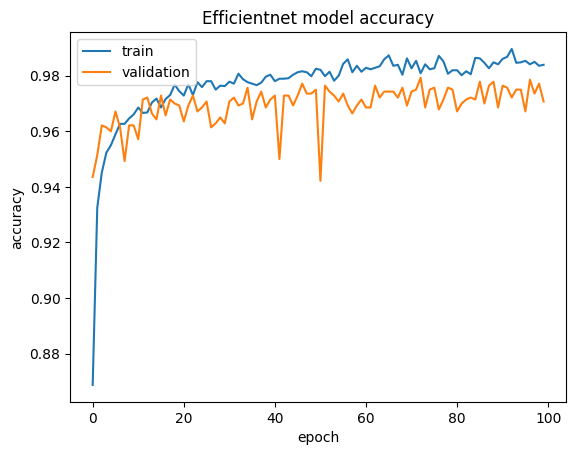

In [23]:
def plot_hist(efficientnet_b0):
    plt.plot(efficientnet_b0.history["accuracy"])
    plt.plot(efficientnet_b0.history["val_accuracy"])
    plt.title("Efficientnet model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(efficientnet_b0)

In [24]:
test_loss, test_accuracy = e_model_b0.evaluate(X_train,Y_train)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

175/175 [==============================] - 65s 370ms/step - loss: 0.0178 - accuracy: 0.9968
Test Accuracy: 99.68%


In [25]:
test_loss, test_accuracy = e_model_b0.evaluate(X_test, Y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

44/44 [==============================] - 15s 334ms/step - loss: 0.0875 - accuracy: 0.9707
Test Accuracy: 97.07%


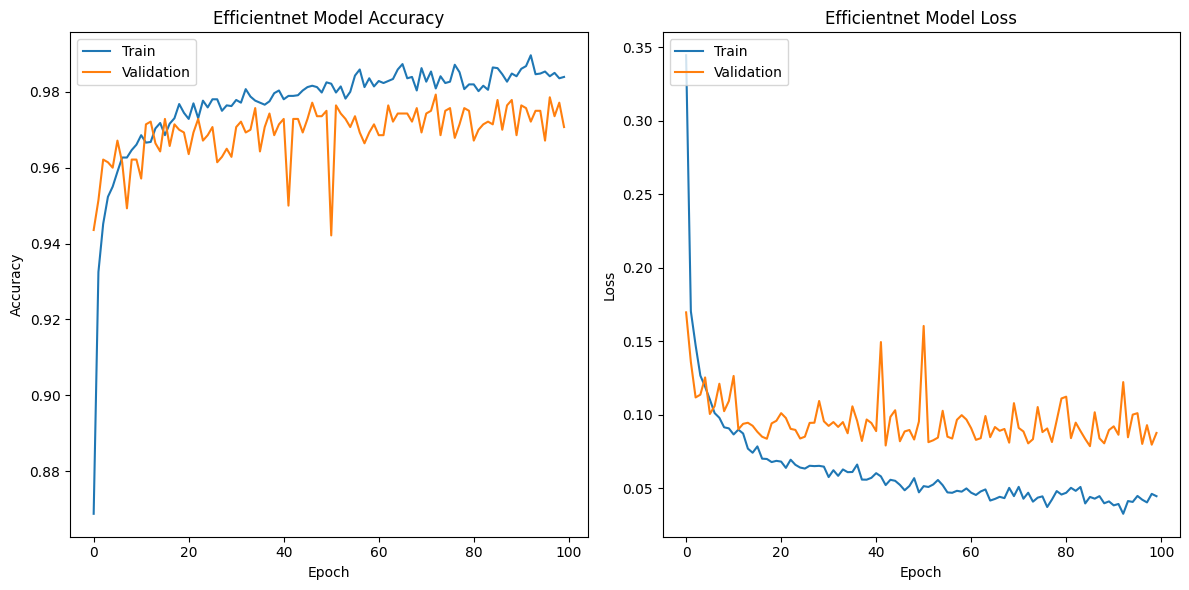

In [26]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(efficientnet_b0.history['accuracy'])
plt.plot(efficientnet_b0.history['val_accuracy'])
plt.title('Efficientnet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(efficientnet_b0.history['loss'])
plt.plot(efficientnet_b0.history['val_loss'])
plt.title('Efficientnet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(e_model_b0.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

44/44 [==============================] - 15s 347ms/step
[0 0 0 ... 6 6 6]
(1400,)


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[200,   0,   0,   0,   0,   0,   0],
       [  0, 200,   0,   0,   0,   0,   0],
       [  0,   1, 199,   0,   0,   0,   0],
       [  0,   0,   0, 195,   5,   0,   0],
       [  0,   0,   0,   3, 197,   0,   0],
       [  0,   1,   0,   0,   0, 176,  23],
       [  0,   0,   0,   0,   0,   8, 192]], dtype=int64)

In [29]:
print(classification_report(Y_test, y_pred,  digits=7,target_names = CATEGORIES))

                      precision    recall  f1-score   support

  Corn___Common_Rust  1.0000000 1.0000000 1.0000000       200
      Corn___Healthy  0.9900990 1.0000000 0.9950249       200
    Invalid___Images  1.0000000 0.9950000 0.9974937       200
    Potato___Healthy  0.9848485 0.9750000 0.9798995       200
Potato___Late_Blight  0.9752475 0.9850000 0.9800995       200
   Rice___Brown_Spot  0.9565217 0.8800000 0.9166667       200
      Rice___Healthy  0.8930233 0.9600000 0.9253012       200

            accuracy                      0.9707143      1400
           macro avg  0.9713914 0.9707143 0.9706408      1400
        weighted avg  0.9713914 0.9707143 0.9706408      1400



In [30]:
import pandas as pd
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

<Axes: title={'center': 'Confusion Matrix'}>

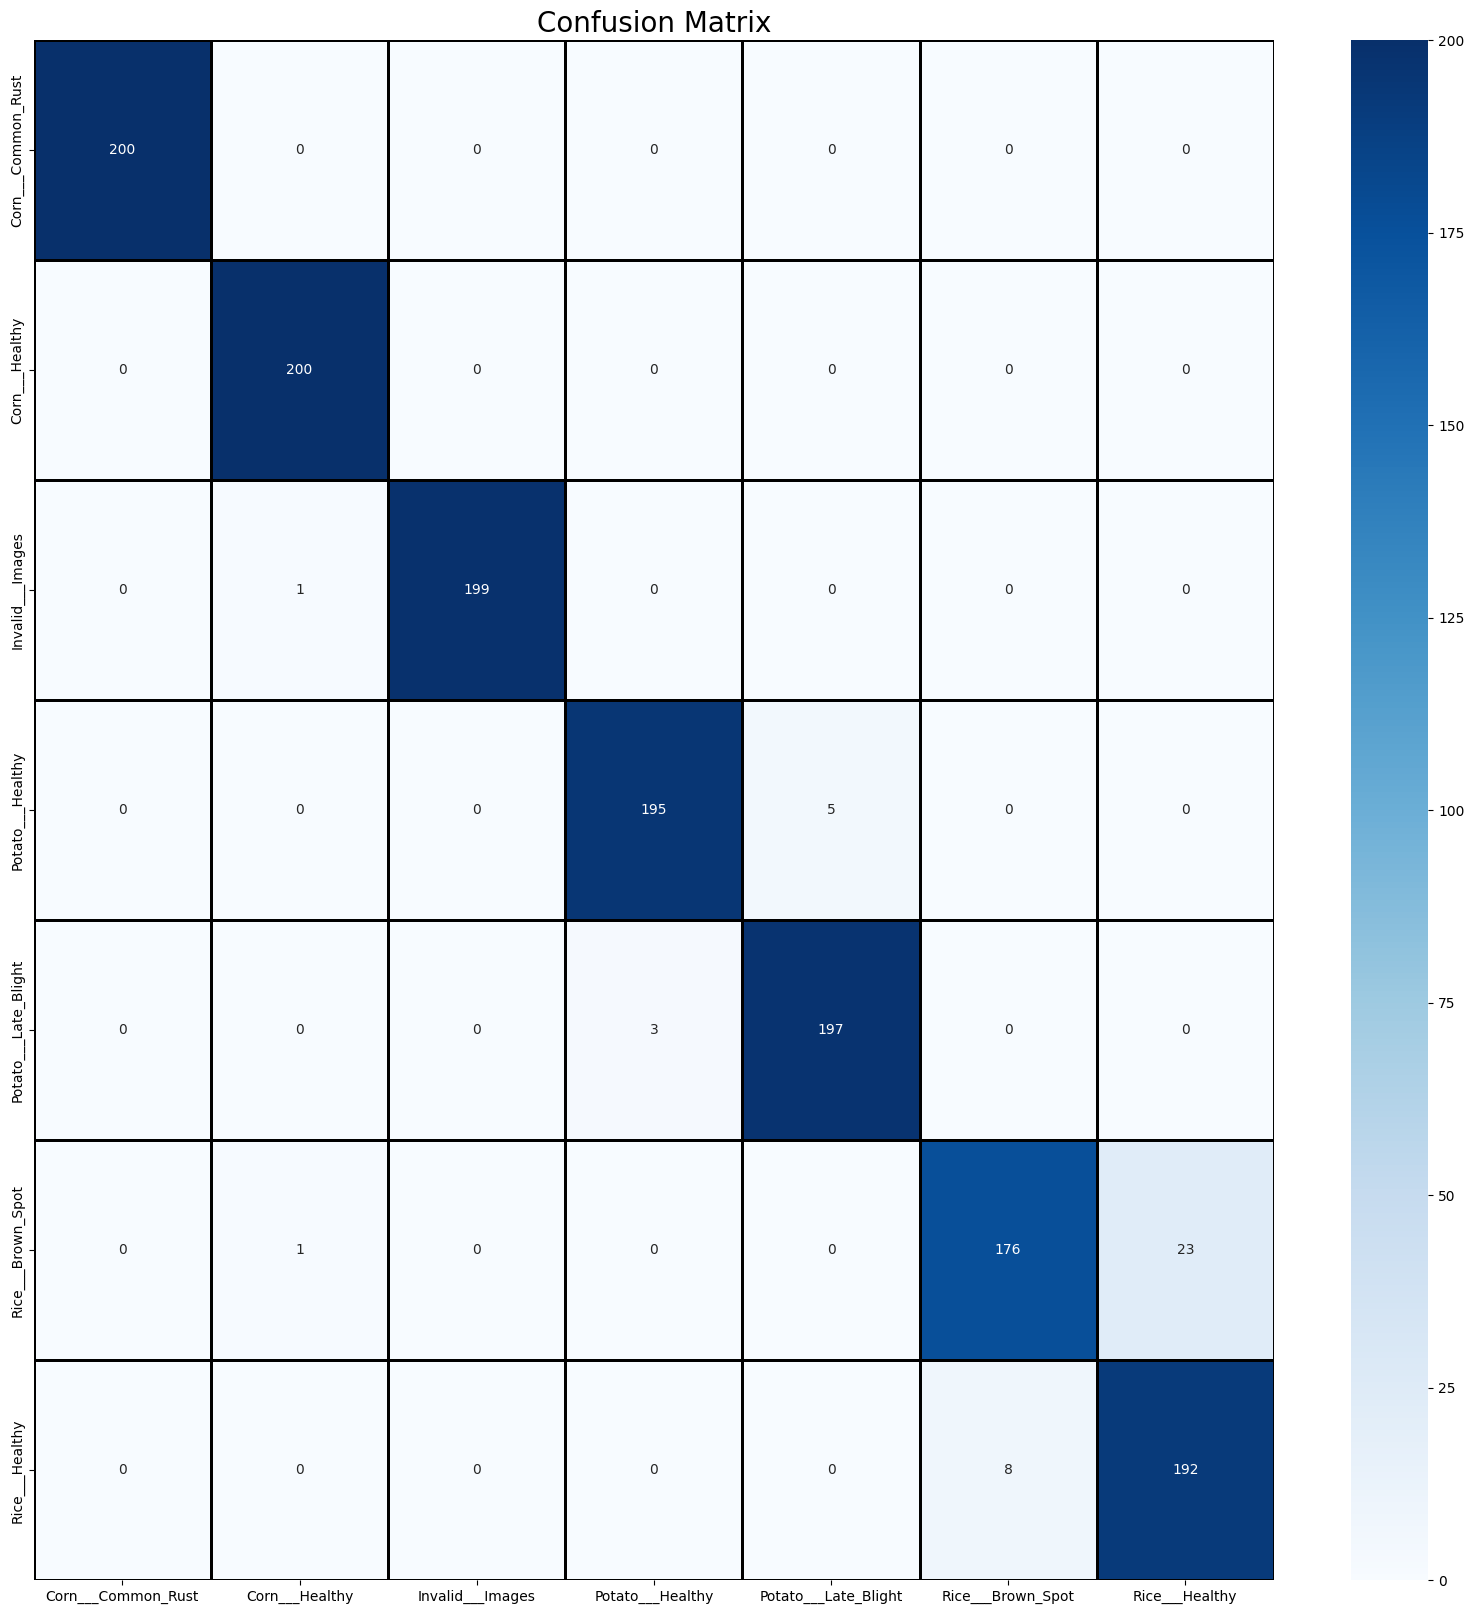

In [31]:
import seaborn as sns
plt.figure(figsize = (20,20))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

In [ ]:
import numpy as np
import random
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
def generate_grad_cam(model, img_array, layer_name):
    img_array_expanded = np.expand_dims(img_array, axis=0)
    grad_model = Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array_expanded)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output.numpy(), weights.numpy()) 

    cam = cv2.resize(cam, (img_array.shape[1], img_array.shape[0]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap
last_conv_layer = 'top_activation'

In [ ]:
def generate_saliency_map(model, img_array):
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_prediction = tf.reduce_max(predictions)

    gradients = tape.gradient(top_prediction, img_tensor)
    normalized_gradients = gradients / (tf.reduce_max(tf.abs(gradients)) + 1e-8)

    saliency_map = tf.reduce_sum(tf.abs(normalized_gradients), axis=-1)
    return saliency_map.numpy()

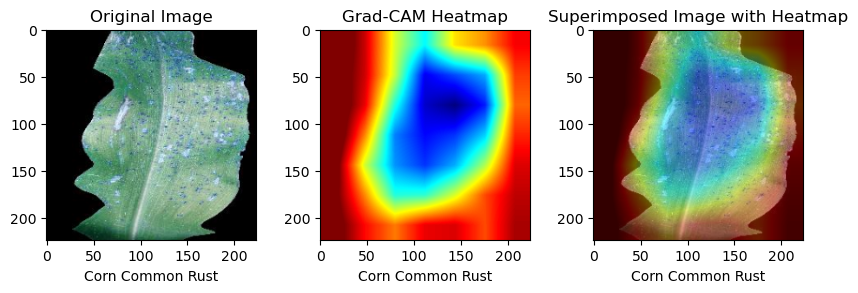

In [ ]:
index_1 = random.choice(np.where(Y_test == 0)[0])  
index_2 = random.choice(np.where(Y_test == 1)[0]) 


sample_image_1 = X_test[index_1]
sample_image_2 = X_test[index_2]


heatmap_1 = generate_grad_cam(e_model_b0, sample_image_1, last_conv_layer)
heatmap_2 = generate_grad_cam(e_model_b0, sample_image_2, last_conv_layer)


heatmap_1_resized = cv2.resize(heatmap_1, (sample_image_1.shape[1], sample_image_1.shape[0]))


heatmap_1_resized_colored = cv2.applyColorMap(np.uint8(255 * heatmap_1_resized), cv2.COLORMAP_JET)


img_array_1 = np.uint8(255 * sample_image_1)

superimposed_img_1 = cv2.addWeighted(img_array_1, 0.6, heatmap_1_resized_colored, 0.4, 0)


plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(img_array_1)
plt.title('Original Image')
plt.xlabel("Corn Common Rust")

plt.subplot(2, 3, 2)
plt.imshow(heatmap_1_resized_colored)
plt.title('Grad-CAM Heatmap')
plt.xlabel("Corn Common Rust")

plt.subplot(2, 3, 3)
plt.imshow(superimposed_img_1)
plt.title('Superimposed Image with Heatmap')
plt.xlabel("Corn Common Rust")
plt.show()




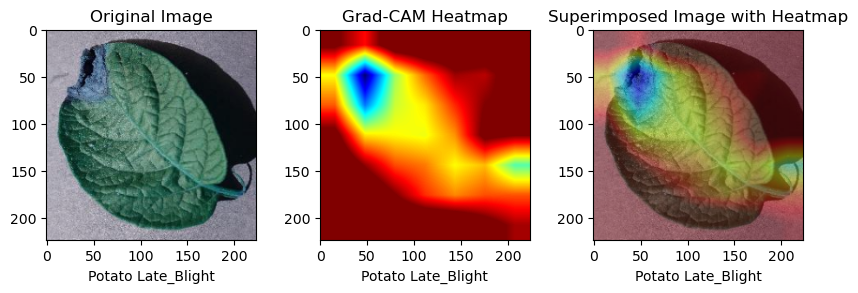

In [ ]:
index_1 = random.choice(np.where(Y_test == 3)[0])  
index_2 = random.choice(np.where(Y_test == 4)[0]) 


sample_image_1 = X_test[index_1]
sample_image_2 = X_test[index_2]


heatmap_1 = generate_grad_cam(e_model_b0, sample_image_1, last_conv_layer)
heatmap_2 = generate_grad_cam(e_model_b0, sample_image_2, last_conv_layer)


heatmap_1_resized = cv2.resize(heatmap_1, (sample_image_1.shape[1], sample_image_1.shape[0]))


heatmap_1_resized_colored = cv2.applyColorMap(np.uint8(255 * heatmap_1_resized), cv2.COLORMAP_JET)


img_array_1 = np.uint8(255 * sample_image_1)

superimposed_img_1 = cv2.addWeighted(img_array_1, 0.6, heatmap_1_resized_colored, 0.4, 0)


plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(img_array_1)
plt.title('Original Image')
plt.xlabel("Potato Late_Blight")

plt.subplot(2, 3, 2)
plt.imshow(heatmap_1_resized_colored)
plt.title('Grad-CAM Heatmap')
plt.xlabel("Potato Late_Blight")

plt.subplot(2, 3, 3)
plt.imshow(superimposed_img_1)
plt.title('Superimposed Image with Heatmap')
plt.xlabel("Potato Late_Blight")
plt.show()




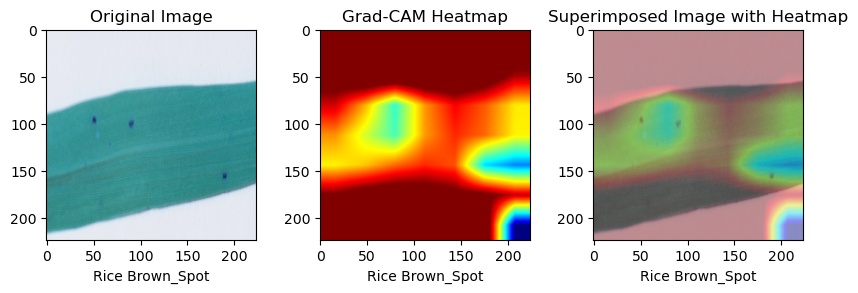

In [ ]:
index_1 = random.choice(np.where(Y_test == 4)[0])  
index_2 = random.choice(np.where(Y_test == 5)[0]) 


sample_image_1 = X_test[index_1]
sample_image_2 = X_test[index_2]


heatmap_1 = generate_grad_cam(e_model_b0, sample_image_1, last_conv_layer)
heatmap_2 = generate_grad_cam(e_model_b0, sample_image_2, last_conv_layer)


heatmap_1_resized = cv2.resize(heatmap_1, (sample_image_1.shape[1], sample_image_1.shape[0]))
heatmap_1_resized_colored = cv2.applyColorMap(np.uint8(255 * heatmap_1_resized), cv2.COLORMAP_JET)
img_array_1 = np.uint8(255 * sample_image_1)

superimposed_img_1 = cv2.addWeighted(img_array_1, 0.6, heatmap_1_resized_colored, 0.4, 0)


plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(img_array_1)
plt.title('Original Image')
plt.xlabel("Rice Brown_Spot")

plt.subplot(2, 3, 2)
plt.imshow(heatmap_1_resized_colored)
plt.title('Grad-CAM Heatmap')
plt.xlabel("Rice Brown_Spot")

plt.subplot(2, 3, 3)
plt.imshow(superimposed_img_1)
plt.title('Superimposed Image with Heatmap')
plt.xlabel("Rice Brown_Spot")
plt.show()




1/1 [==============================] - 0s 63ms/step


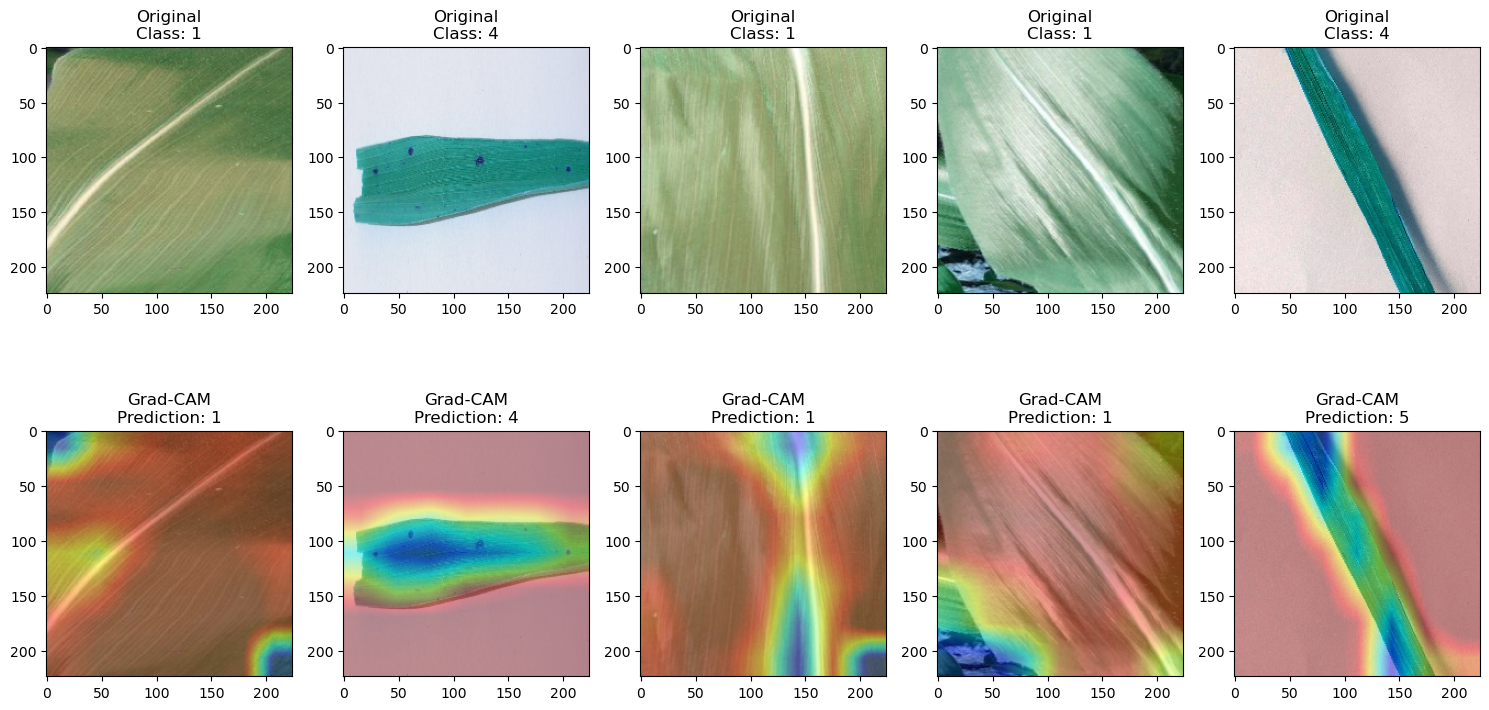

In [ ]:
num_images_to_visualize = 5
sample_indices = np.random.choice(len(X_test), num_images_to_visualize, replace=False)
sample_images = X_test[sample_indices]

plt.figure(figsize=(15, 8))
for i, sample_image in enumerate(sample_images):
    heatmap = generate_grad_cam(e_model_b0, sample_image, last_conv_layer)

    img_array = np.uint8(255 * sample_image)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_array, 0.6, heatmap, 0.4, 0)

    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(img_array)
    plt.title(f'Original\nClass: {Y_test[sample_indices[i]]}')

    plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM\nPrediction: {np.argmax(e_model_b0.predict(np.expand_dims(sample_image, axis=0)))}')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 61ms/step


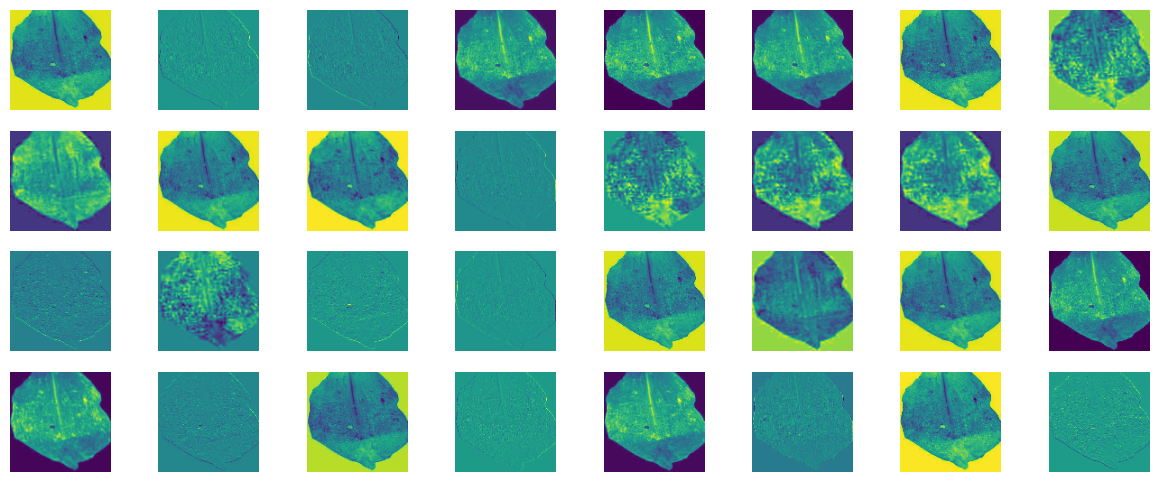

In [ ]:
sample_image_1 = X_test[5]

activation_model = Model(inputs=e_model_b0.input, outputs=e_model_b0.layers[2].output) 
activations = activation_model.predict(np.expand_dims(sample_image_1, axis=0))
plt.figure(figsize=(15, 6))
for i in range(activations.shape[-1]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


1/1 [==============================] - 0s 108ms/step


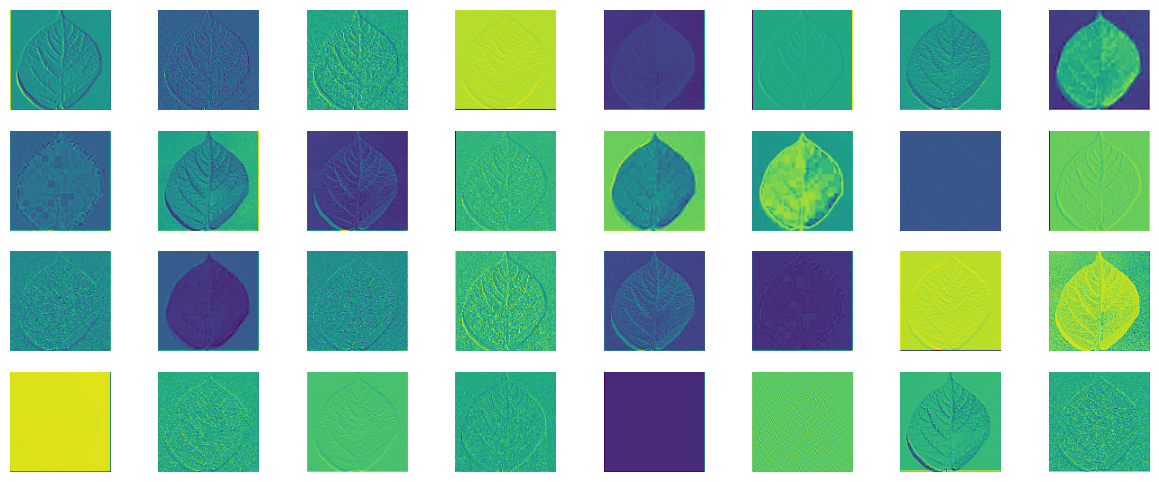

In [ ]:
index_1 = random.choice(np.where(Y_test == 2)[0])  
sample_image_1 = X_test[index_1]

activation_model = Model(inputs=e_model_b0.input, outputs=e_model_b0.layers[4].output) 
activations = activation_model.predict(np.expand_dims(sample_image_1, axis=0))
plt.figure(figsize=(15, 6))
for i in range(activations.shape[-1]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


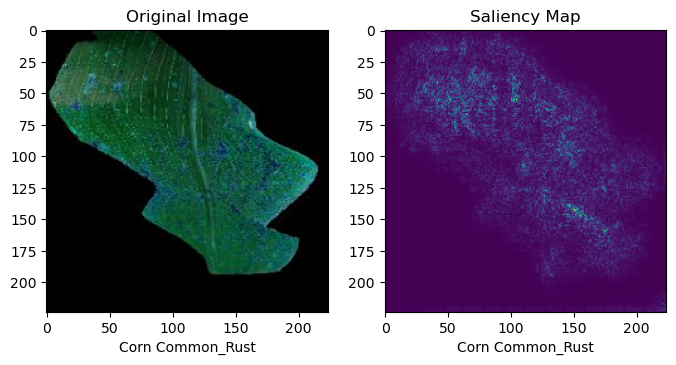

In [ ]:
index_1 = random.choice(np.where(Y_test == 0)[0])  
sample_image = X_test[index_1]


sample_image = np.expand_dims(sample_image, axis=0)
saliency_map = generate_saliency_map(e_model_b0, sample_image)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0])  
plt.title('Original Image')
plt.xlabel('Corn Common_Rust')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map[0], cmap='viridis') 
plt.title('Saliency Map')
plt.xlabel('Corn Common_Rust')

plt.show()

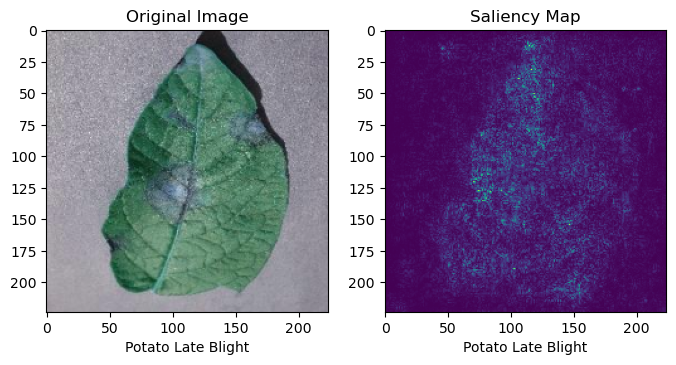

In [ ]:
index_1 = random.choice(np.where(Y_test == 3)[0])  
sample_image = X_test[index_1]


sample_image = np.expand_dims(sample_image, axis=0)
saliency_map = generate_saliency_map(e_model_b0, sample_image)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0])  
plt.title('Original Image')
plt.xlabel('Potato Late Blight')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map[0], cmap='viridis') 
plt.title('Saliency Map')
plt.xlabel('Potato Late Blight')

plt.show()

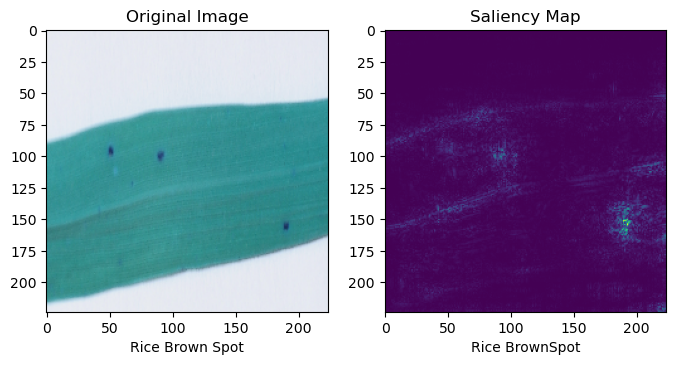

In [ ]:
index_1 = random.choice(np.where(Y_test == 4)[0])  
sample_image = X_test[index_1]


sample_image = np.expand_dims(sample_image, axis=0)
saliency_map = generate_saliency_map(e_model_b0, sample_image)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0])  
plt.title('Original Image')
plt.xlabel('Rice Brown Spot')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map[0], cmap='viridis') 
plt.title('Saliency Map')
plt.xlabel('Rice BrownSpot')

plt.show()

In [17]:
def load_model():
	with open('model/efficientnet_b0_model.json', 'r') as json_file:
		loaded_model_json = json_file.read()

	loaded_model = tf.keras.models.model_from_json(loaded_model_json)
	return loaded_model

e_model_b0 = load_model()
e_model_b0.load_weights('model/efficientnet_b0_model.h5')

In [18]:
e_model_b0.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x000002553D208690>>

In [27]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model

feature_extraction_model = Model(inputs=e_model_b0.input, outputs=e_model_b0.get_layer('block2a_expand_activation').output)

X_train_features = feature_extraction_model.predict(X_train)
X_test_features = feature_extraction_model.predict(X_test)

# Flatten and normalize features
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flatten = X_test_features.reshape(X_test_features.shape[0], -1)

# Normalize features
X_train_normalized = X_train_flatten / 255.0
X_test_normalized = X_test_flatten / 255.0

# Train SVM model
svm_model = svm.SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_normalized, Y_train)

135/175 [======================>.......] - ETA: 29s

ResourceExhaustedError: Graph execution error:

Detected at node model_2/block2a_expand_activation/Sigmoid defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\zaidm\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\zaidm\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\zaidm\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\zaidm\AppData\Local\Temp\ipykernel_7392\2892678614.py", line 8, in <module>

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\layers\core\activation.py", line 59, in call

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\efficientnet\model.py", line 115, in swish

  File "c:\Users\zaidm\Desktop\corp classification\myenv\Lib\site-packages\keras\src\backend.py", line 5915, in sigmoid

OOM when allocating tensor with shape[32,112,112,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node model_2/block2a_expand_activation/Sigmoid}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_17844]

In [20]:
from sklearn.svm import SVC

features_train = e_model_b0.predict(X_train)
features_test = e_model_b0.predict(X_test)
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)

svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(features_train_flat, Y_train)

44/44 [==============================] - 16s 330ms/step


SVC(gamma='auto')

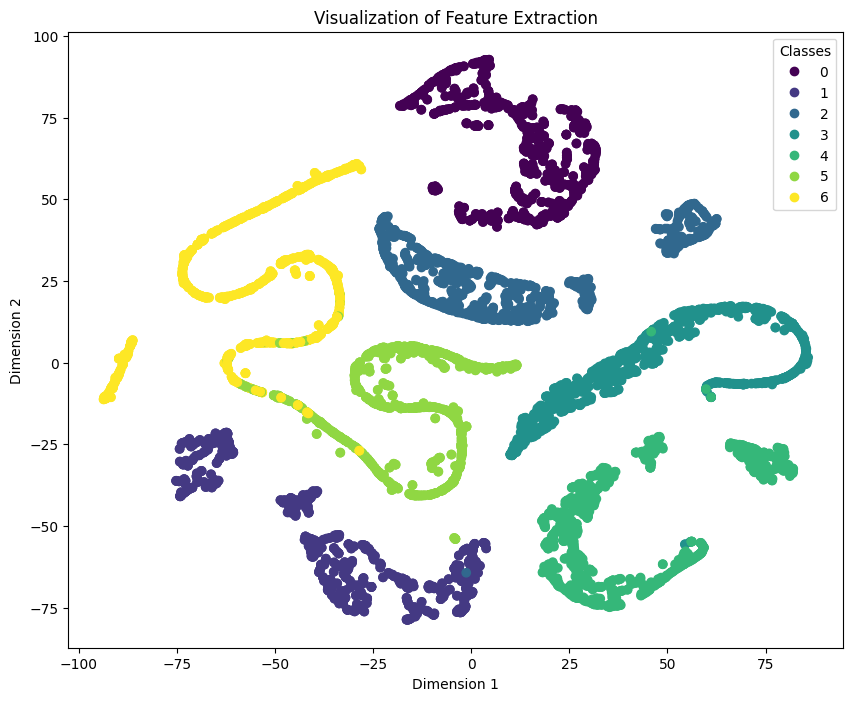

In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

features_combined = np.concatenate([features_train_flat, features_test_flat], axis=0)
labels_combined = np.concatenate([Y_train, Y_test], axis=0)

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_combined)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_combined, cmap='viridis')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title('Visualization of Feature Extraction')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [33]:
test_accuracy = svm.score(features_test_flat, Y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 97.29%


In [22]:
import joblib
joblib.dump(svm, 'model/svm_model.joblib')

['model/svm_model.joblib']

In [34]:
print("Number of features expected by the model:", svm.n_features_in_)

Number of features expected by the model: 7


In [35]:
x_pred = svm.predict(features_train_flat)
print(classification_report(Y_train, x_pred,digits=7,target_names = CATEGORIES))

                      precision    recall  f1-score   support

  Corn___Common_Rust  1.0000000 1.0000000 1.0000000       800
      Corn___Healthy  0.9962640 1.0000000 0.9981285       800
    Invalid___Images  1.0000000 1.0000000 1.0000000       800
    Potato___Healthy  1.0000000 1.0000000 1.0000000       800
Potato___Late_Blight  1.0000000 1.0000000 1.0000000       800
   Rice___Brown_Spot  0.9911728 0.9825000 0.9868173       800
      Rice___Healthy  0.9863184 0.9912500 0.9887781       800

            accuracy                      0.9962500      5600
           macro avg  0.9962507 0.9962500 0.9962463      5600
        weighted avg  0.9962507 0.9962500 0.9962463      5600



In [36]:
y_pred = svm.predict(features_test_flat)
print(classification_report(Y_test, y_pred,digits=7,target_names = CATEGORIES))

                      precision    recall  f1-score   support

  Corn___Common_Rust  1.0000000 1.0000000 1.0000000       200
      Corn___Healthy  0.9900990 1.0000000 0.9950249       200
    Invalid___Images  1.0000000 0.9950000 0.9974937       200
    Potato___Healthy  0.9848485 0.9750000 0.9798995       200
Potato___Late_Blight  0.9752475 0.9850000 0.9800995       200
   Rice___Brown_Spot  0.9523810 0.9000000 0.9254499       200
      Rice___Healthy  0.9095238 0.9550000 0.9317073       200

            accuracy                      0.9728571      1400
           macro avg  0.9731571 0.9728571 0.9728107      1400
        weighted avg  0.9731571 0.9728571 0.9728107      1400



Precision: 0.9962507399410577
Recall: 0.99625
F1 Score: 0.9962462699583942


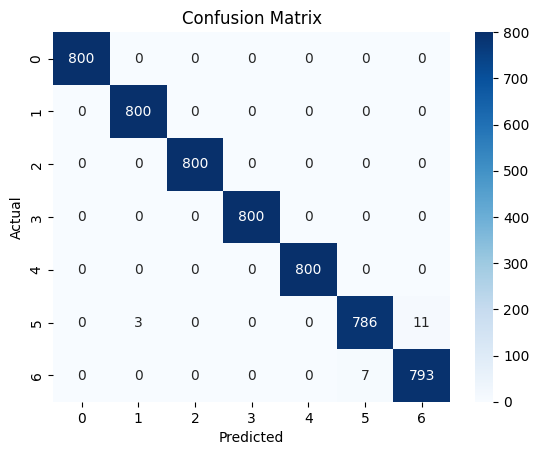

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Make predictions
x_pred = svm.predict(features_train_flat)

# Calculate evaluation metrics
precision = precision_score(Y_train, x_pred, average='weighted')
recall = recall_score(Y_train, x_pred, average='weighted')
f1 = f1_score(Y_train, x_pred, average='weighted')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
conf_matrix = confusion_matrix(Y_train, x_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Precision: 0.9731571116295302
Recall: 0.9728571428571429
F1 Score: 0.9728106854958852


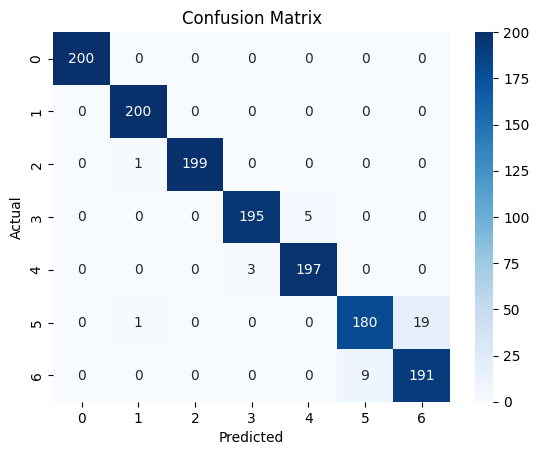

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Make predictions
y_pred = svm.predict(features_test_flat)

# Calculate evaluation metrics
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()